In [1]:
!git clone https://github.com/xserra/audio-coding-materials.git
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import IPython.display as ipd
from scipy.io.wavfile import read
import torch.nn as nn

Cloning into 'audio-coding-materials'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 44 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (44/44), 12.42 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [29]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.linspace(0, sound_array.size/sampling_rate, sound_array.size)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import soundfile as sf

# Dataset for loading and segmenting audio
class AudioDataset(Dataset):
    def __init__(self, signal, segment_length=16000):
        self.signal = signal
        self.segment_length = segment_length

    def __len__(self):
        return len(self.signal) // self.segment_length

    def __getitem__(self, idx):
        start = idx * self.segment_length
        end = start + self.segment_length
        return self.signal[start:end]

# Autoencoder architecture with Conv1D and ConvTranspose1D
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8, kernel_size=4, stride=2, padding=1),  # Output size reduced by stride
            nn.ReLU(),
            nn.Conv1d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1),  # Another downsampling step
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),  # Further reduction
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),  # Final encoder layer
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),  # Upsampling
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),  # Upsampling
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=8, kernel_size=4, stride=2, padding=1),   # Upsampling
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=1, kernel_size=4, stride=2, padding=1)     # Final output
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train_autoencoder(model, data_loader, num_epochs, device):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # To store loss values for plotting later
    training_loss = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        # Switch model to training mode
        model.train()

        for i, batch in enumerate(data_loader):
            batch = batch.unsqueeze(1).to(device)  # Add channel dimension [B, 1, L]
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch)
            loss = criterion(outputs, batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate average loss over the epoch
        avg_loss = running_loss / len(data_loader)
        training_loss.append(avg_loss)

        # Print progress at each epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.6f}')

        # Optional: Visualize original vs reconstructed at every few epochs
        if (epoch + 1) % 10 == 0:  # Plot every 10 epochs
            visualize_reconstruction(model, data_loader, device)

    # Plot loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training Loss over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_reconstruction(model, data_loader, device):
    # Switch model to evaluation mode
    model.eval()

    # Get a batch of data
    with torch.no_grad():
        batch = next(iter(data_loader))
        batch = batch.unsqueeze(1).to(device)  # Add channel dimension [B, 1, L]

        # Get the model's reconstruction of the batch
        recon = model(batch)

    # Convert tensors to numpy for plotting
    original = batch.squeeze().cpu().numpy()
    reconstructed = recon.squeeze().cpu().numpy()

    # Plot original vs reconstructed for first 5 samples in the batch
    num_samples = 5
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Plot original signal
        axs[i, 0].plot(original[i])
        axs[i, 0].set_title(f'Original Signal {i + 1}')
        axs[i, 0].set_xlim([0, len(original[i])])

        # Plot reconstructed signal
        axs[i, 1].plot(reconstructed[i])
        axs[i, 1].set_title(f'Reconstructed Signal {i + 1}')
        axs[i, 1].set_xlim([0, len(reconstructed[i])])

    plt.tight_layout()
    plt.show()

# Encode the audio into its latent representation
def encode_audio(model, audio_signal, device):
    model.eval()
    if isinstance(audio_signal, np.ndarray):
        audio_signal = torch.from_numpy(audio_signal)
    with torch.no_grad():
        audio_signal = audio_signal.unsqueeze(0).unsqueeze(1).to(device)  # [1, 1, L]
        latent = model.encoder(audio_signal)
    return latent

# Decode the latent representation back to the original space
def decode_audio(model, latent_rep, device):
    model.eval()
    with torch.no_grad():
        reconstructed = model.decoder(latent_rep).squeeze().cpu().numpy()
    return reconstructed

# Plot the original and reconstructed audio signals
def plot_signals(original, reconstructed, sample_rate):
    plt.figure(figsize=(10, 4))
    plt.plot(original, label='Original Signal')
    plt.plot(reconstructed, label='Reconstructed Signal', linestyle='dashed')
    plt.legend()
    plt.title('Original vs Reconstructed Audio Signal')
    plt.show()

# Save the reconstructed audio to a file
def save_audio(reconstructed_signal, sample_rate, filename='reconstructed_audio.wav'):
    sf.write(filename, reconstructed_signal, sample_rate)

Epoch [1/50], Loss: 0.019367
Epoch [2/50], Loss: 0.017323
Epoch [3/50], Loss: 0.015625
Epoch [4/50], Loss: 0.014382
Epoch [5/50], Loss: 0.012882
Epoch [6/50], Loss: 0.011764
Epoch [7/50], Loss: 0.010905
Epoch [8/50], Loss: 0.010282
Epoch [9/50], Loss: 0.010590
Epoch [10/50], Loss: 0.010075


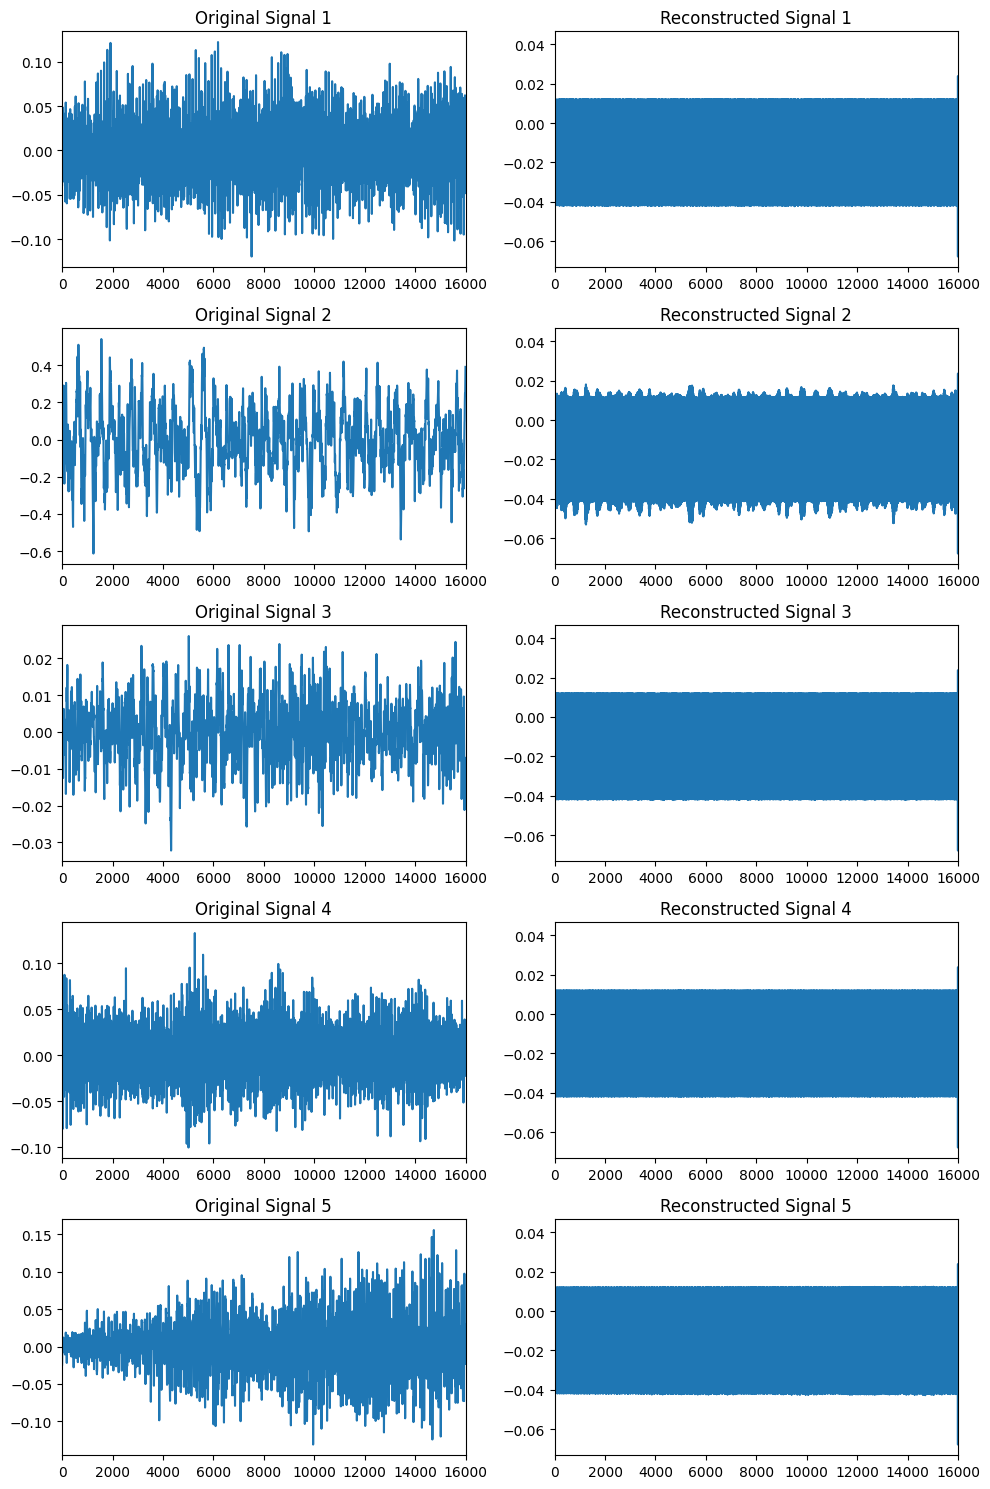

Epoch [11/50], Loss: 0.010538
Epoch [12/50], Loss: 0.009853
Epoch [13/50], Loss: 0.009721
Epoch [14/50], Loss: 0.010076
Epoch [15/50], Loss: 0.010067
Epoch [16/50], Loss: 0.010155
Epoch [17/50], Loss: 0.009897
Epoch [18/50], Loss: 0.010026
Epoch [19/50], Loss: 0.009895
Epoch [20/50], Loss: 0.009637


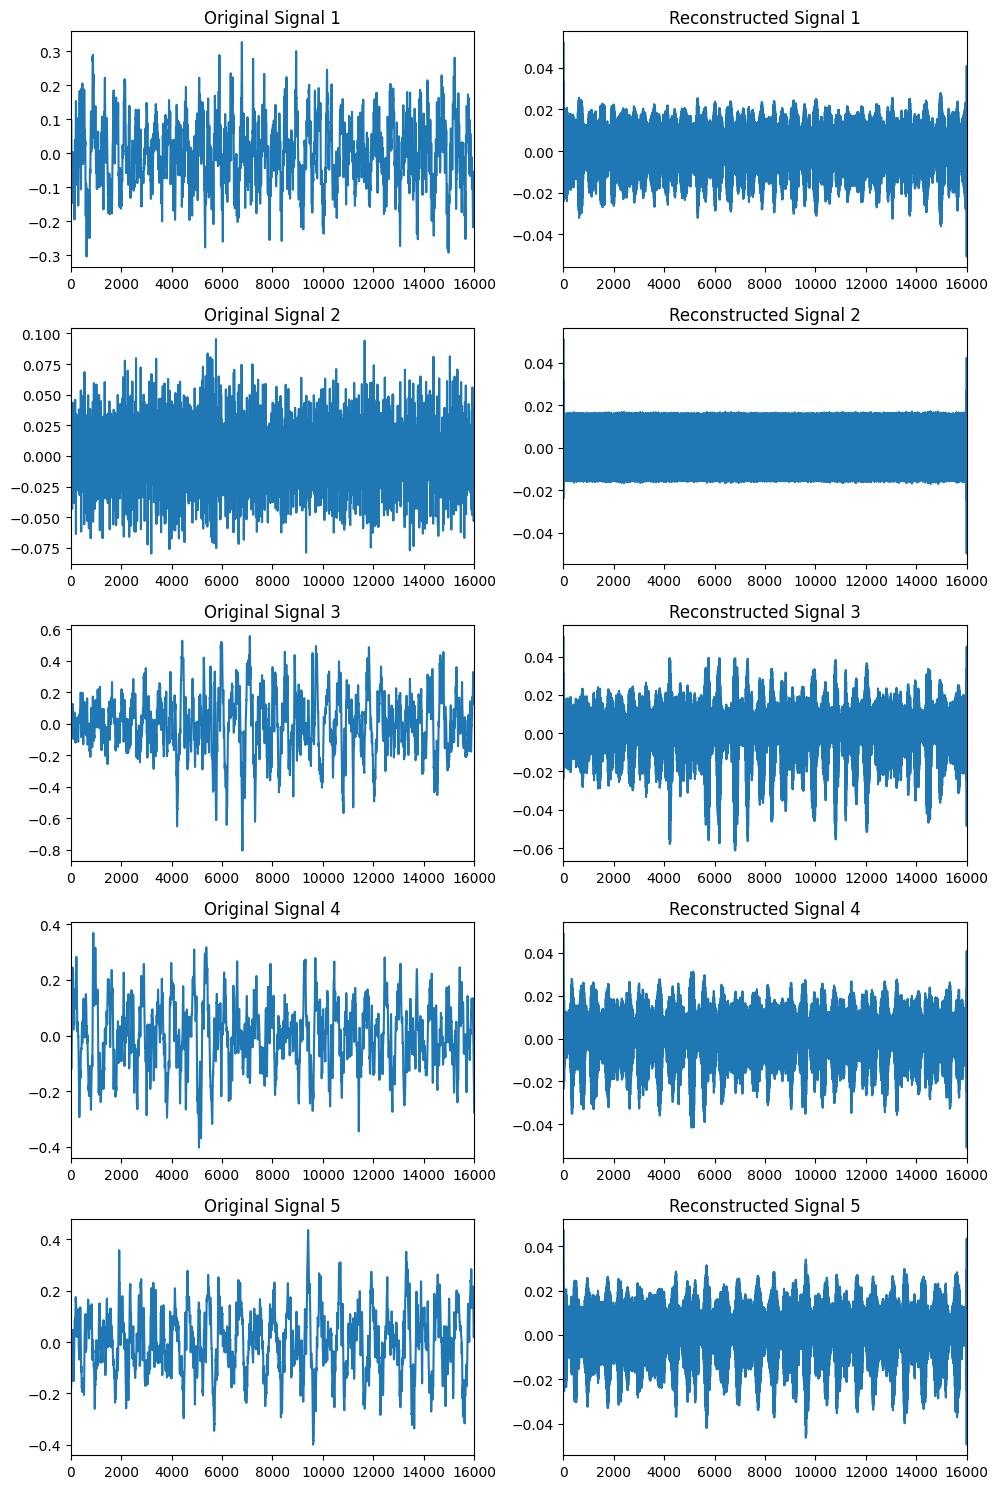

Epoch [21/50], Loss: 0.009578
Epoch [22/50], Loss: 0.010006
Epoch [23/50], Loss: 0.009134
Epoch [24/50], Loss: 0.009350
Epoch [25/50], Loss: 0.009393
Epoch [26/50], Loss: 0.009252
Epoch [27/50], Loss: 0.008912
Epoch [28/50], Loss: 0.008958
Epoch [29/50], Loss: 0.008533
Epoch [30/50], Loss: 0.008191


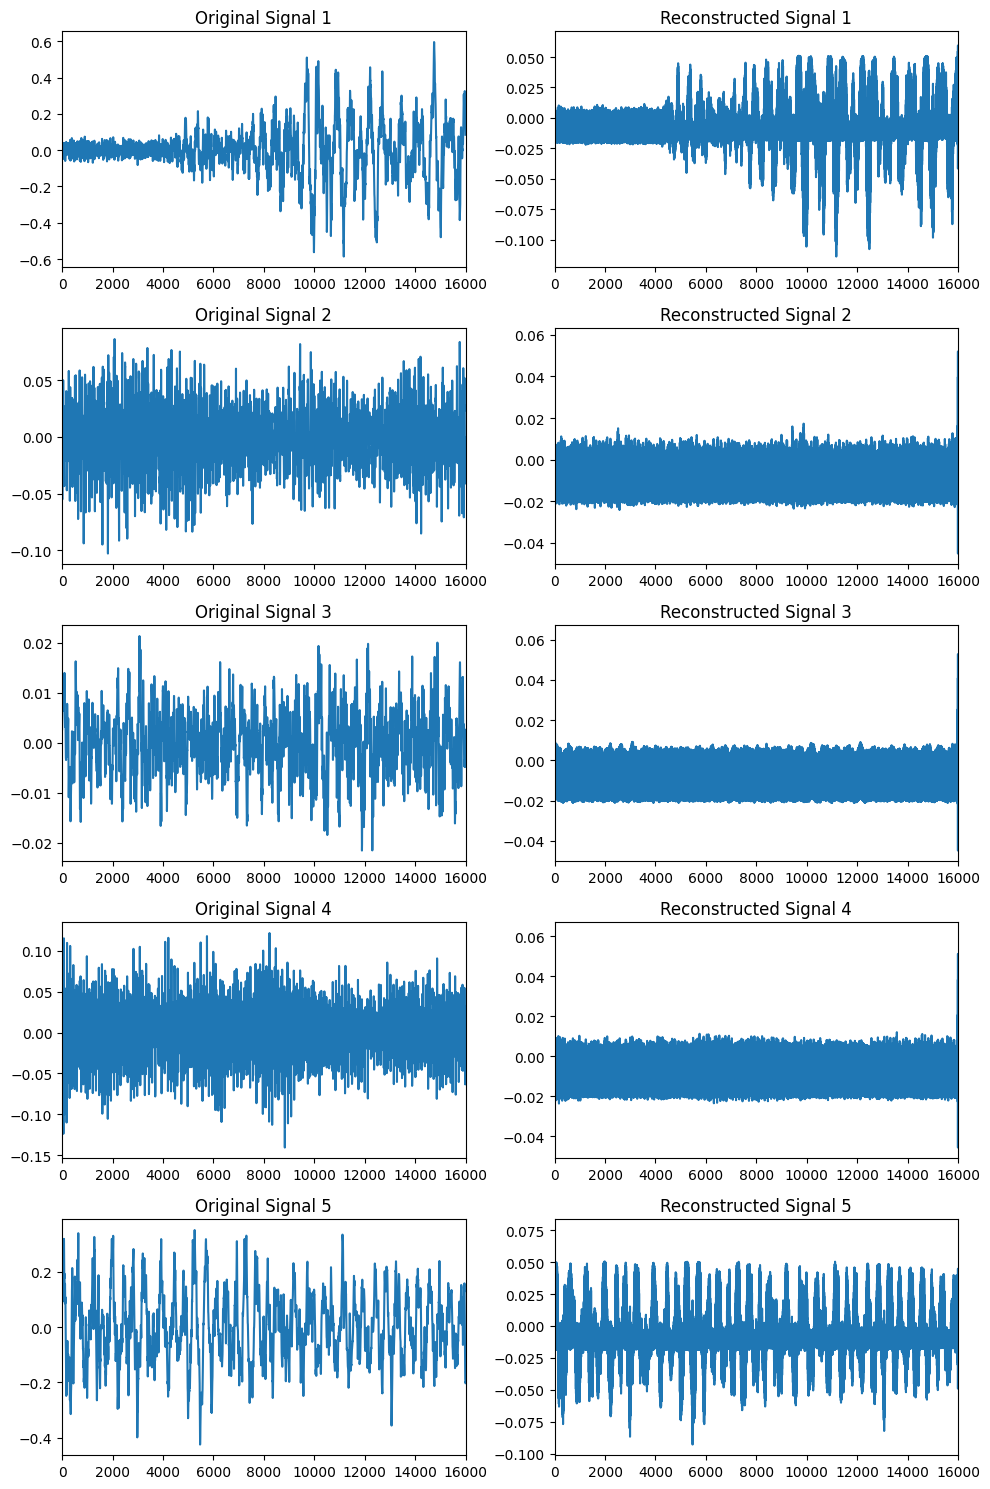

Epoch [31/50], Loss: 0.007673
Epoch [32/50], Loss: 0.007549
Epoch [33/50], Loss: 0.007580
Epoch [34/50], Loss: 0.007282
Epoch [35/50], Loss: 0.006694
Epoch [36/50], Loss: 0.006113
Epoch [37/50], Loss: 0.005982
Epoch [38/50], Loss: 0.005919
Epoch [39/50], Loss: 0.005614
Epoch [40/50], Loss: 0.005400


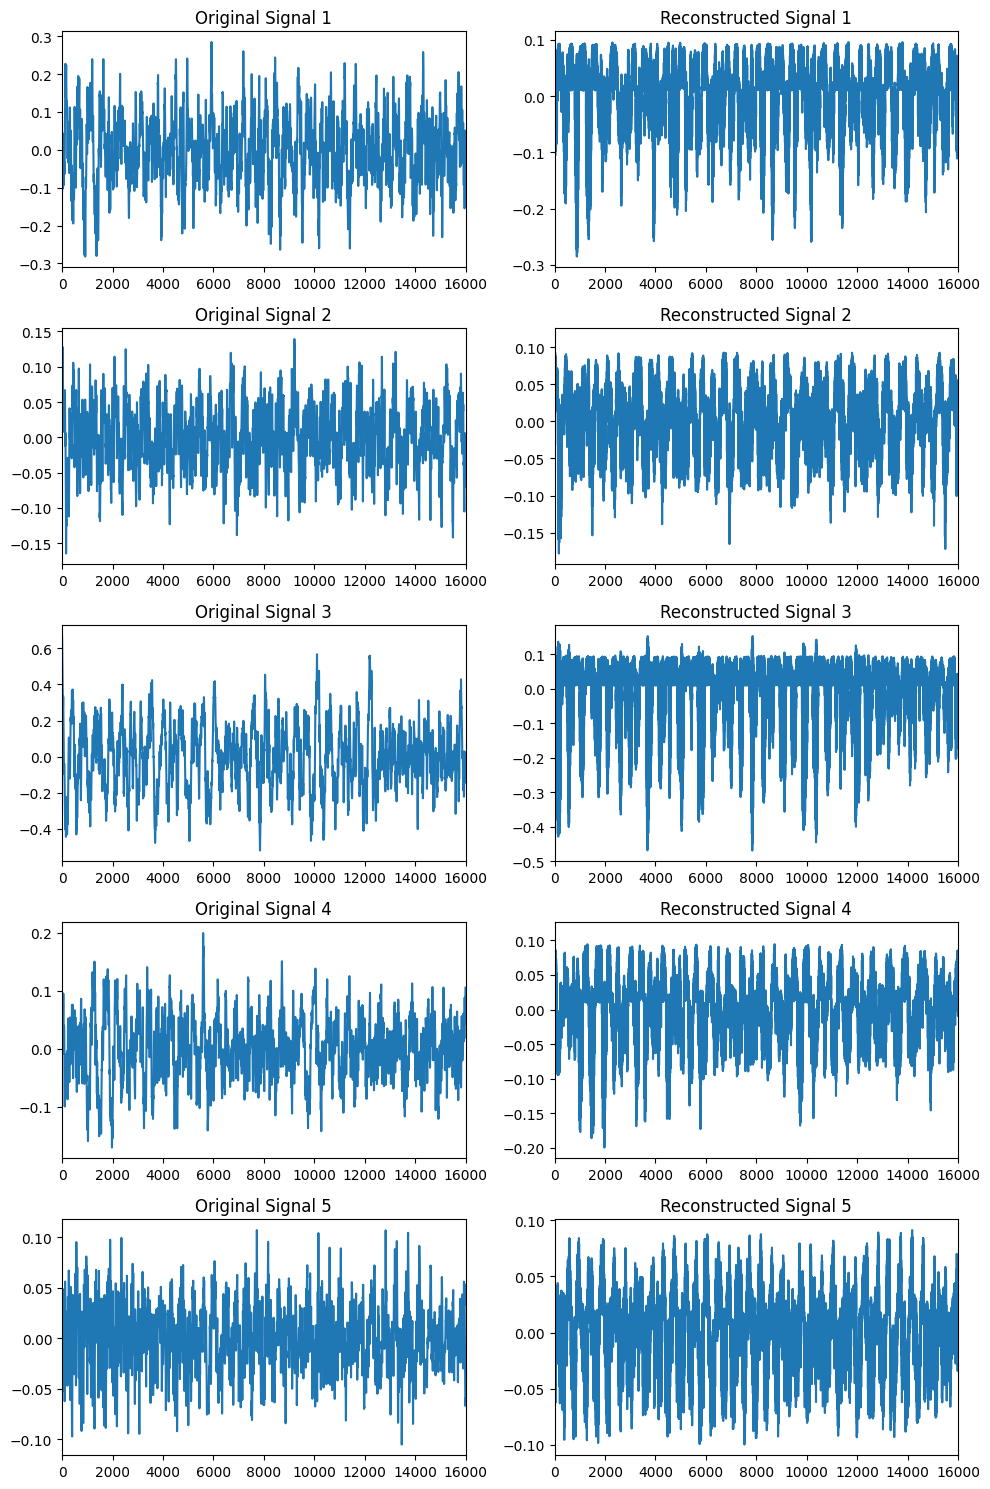

Epoch [41/50], Loss: 0.005096
Epoch [42/50], Loss: 0.005344
Epoch [43/50], Loss: 0.005209
Epoch [44/50], Loss: 0.004793
Epoch [45/50], Loss: 0.004673
Epoch [46/50], Loss: 0.004265
Epoch [47/50], Loss: 0.004327
Epoch [48/50], Loss: 0.003938
Epoch [49/50], Loss: 0.003845
Epoch [50/50], Loss: 0.003603


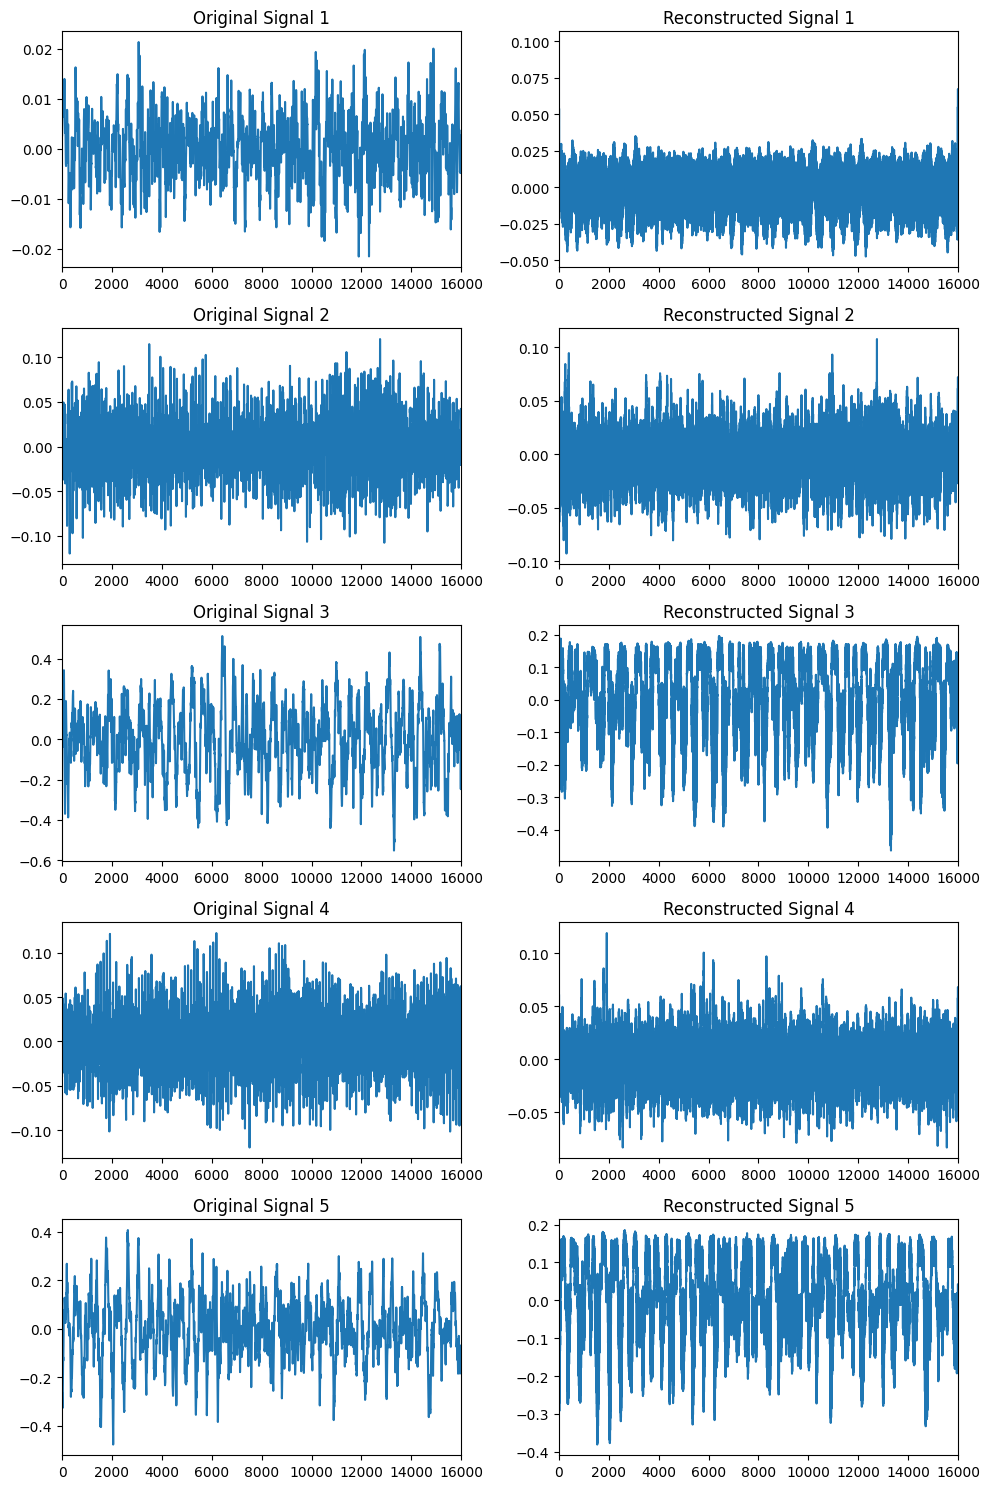

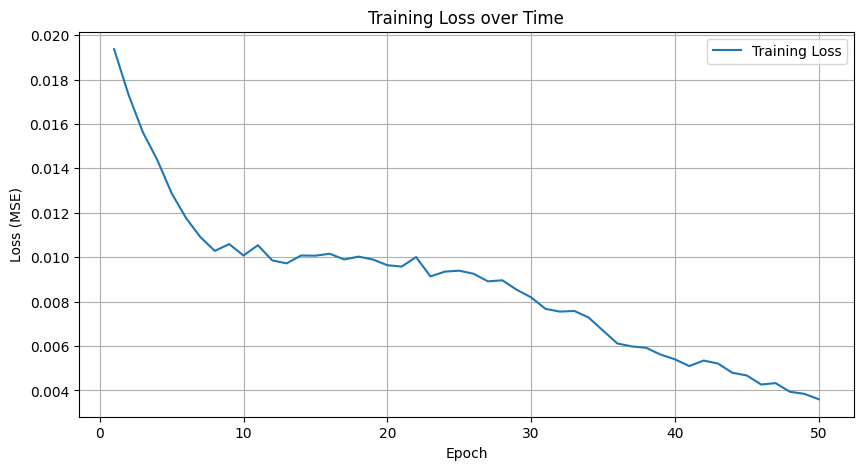

In [25]:
# model training

# Load training audio
audio_signal, sample_rate = read_sound("/content/audio-coding-materials/162095-chinese-orchestra-channel-1.wav")

# Create dataset and data loader
segment_length = 16000
dataset = AudioDataset(audio_signal, segment_length)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)

# Train the model
num_epochs = 50
train_autoencoder(model, data_loader, num_epochs, device)

In [26]:
# Encode and decode an audio signal
audio_signal, sample_rate = read_sound("/content/audio-coding-materials/162095-chinese-orchestra-channel-1.wav")
latent_rep = encode_audio(model, audio_signal, device)
reconstructed_signal = decode_audio(model, latent_rep, device)

# Original signal (in NumPy)
print(f"Original signal size (number of elements): {audio_signal.size}")
# Print the shape of the latent representation
print(f"Shape of latent representation: {latent_rep.shape}")
# Print the total number of elements in the latent representation
print(f"Size of latent representation (number of elements): {latent_rep.numel()}")

# Plot and play original and reconstructed signal
display_sound(audio_signal, sample_rate)
display_sound(reconstructed_signal, sample_rate)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
# Encode and decode an audio signal
audio_signal, sample_rate = read_sound("/content/audio-coding-materials/162095-chinese-orchestra-channel-2.wav")
latent_rep = encode_audio(model, audio_signal, device)
reconstructed_signal = decode_audio(model, latent_rep, device)

# Original signal (in NumPy)
print(f"Original signal size (number of elements): {audio_signal.size}")
# Print the shape of the latent representation
print(f"Shape of latent representation: {latent_rep.shape}")
# Print the total number of elements in the latent representation
print(f"Size of latent representation (number of elements): {latent_rep.numel()}")

# Plot and play original and reconstructed signal
display_sound(audio_signal, sample_rate)
display_sound(reconstructed_signal, sample_rate)

Output hidden; open in https://colab.research.google.com to view.

Original signal size (number of elements): 112076
Shape of latent representation: torch.Size([1, 64, 7004])
Size of latent representation (number of elements): 448256


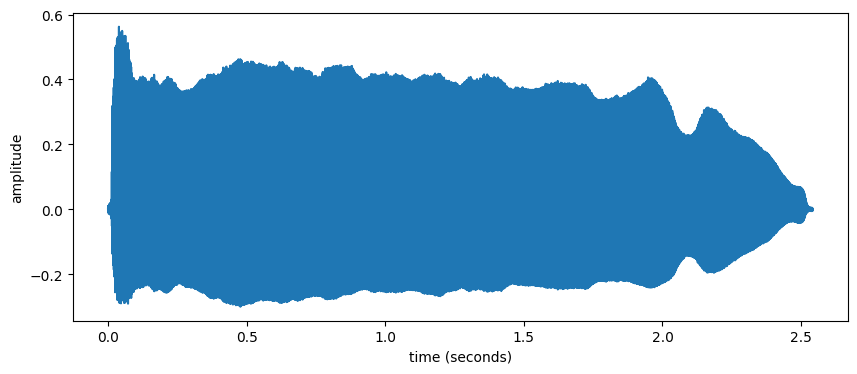

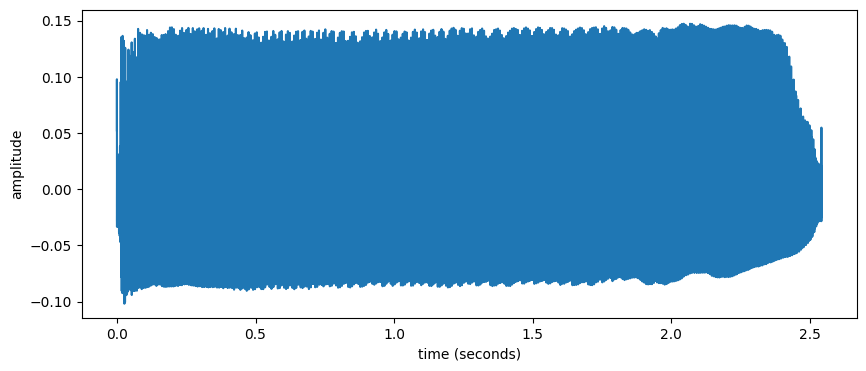

In [30]:
# Encode and decode an audio signal
audio_signal, sample_rate = read_sound("/content/audio-coding-materials/487465-trumpet.wav")
latent_rep = encode_audio(model, audio_signal, device)

# Original signal (in NumPy)
print(f"Original signal size (number of elements): {audio_signal.size}")
# Print the shape of the latent representation
print(f"Shape of latent representation: {latent_rep.shape}")
# Print the total number of elements in the latent representation
print(f"Size of latent representation (number of elements): {latent_rep.numel()}")

reconstructed_signal = decode_audio(model, latent_rep, device)

# Plot and play original and reconstructed signal
display_sound(audio_signal, sample_rate)
display_sound(reconstructed_signal, sample_rate)

In [ ]:
# Print the model summary
summary(model, input_size=(1, 16000))  # Input size: (Channels, Length)